## LAB 5-OPTIONAL - TASK 5 submission. ML 2022-23.
**GANs**


FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**: Andrés Martínez Silva - 904843, Luis Calderón Robustillo -896238


This task is based on Tensorflow documentation about GANs, in particular the tutorial: https://www.tensorflow.org/tutorials/generative/dcgan

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## 0. Intro

In this task you'll see how to generate images similar to those of an existing dataset using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). You have already seen the main ingredients in other labs: [Keras Sequential API](https://www.tensorflow.org/guide/keras) to design the networks and `tf.GradientTape` for the training loop.

In a [Generative Adversarial Network](https://arxiv.org/abs/1406.2661) (GAN),  two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)


### Setup

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kfs_wu7g
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-kfs_wu7g
  Resolved https://github.com/tensorflow/docs to commit 8246c1cba26bb07d9c02c165d83936c5b50825ca
  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You can choose which dataset to use use: MNIST (digits), fashion-MNIST or CIFAR-10. With it, you'll train the generator and the discriminator. The generator will generate images resembling the original dataset images.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
#(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
#(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# careful if you use CIFAR10! patches are 32x32x3 (color) instead of 28x28x1 (grayscale)
#train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 1. Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the *desired output image size* (e.g. 28x28x1). Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
##Provided
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

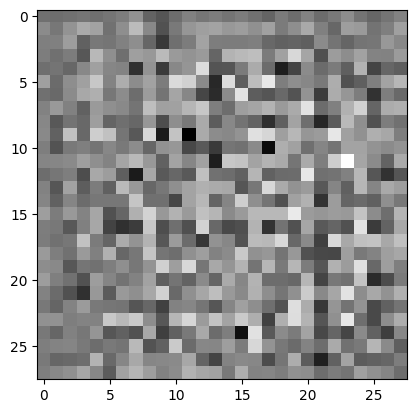

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# if color images
# img = np.uint8(generated_image[0, :, :, :] * 127.5 + 127.5)
# plt.imshow(img)

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

### The Discriminator

The discriminator is a CNN-based image classifier, which you may know pretty well at this point.

### **QUESTION 1**: Can you briefly explain what's the role of the strides used in this network? What's the number of parameters of the first convolutional layer and how do you compute this number?

ANSWER 1: [YOUR ANSWER] (max 4 lines)
The role of the strides is to downsample the input image by reducing its resolution by half: from 28x28 to 14x14, then to 7x7. The first convolutional layer has a total of 1664 parameters, computed as (filter width x filter height x filters in previous layer + 1) x number of filters = (5x5x1 + 1) x 64 = 1664 parameters.

In [ ]:
# Provided
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


Example on how to use the discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00197296]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

### Define **loss functions and optimizers** for both models.

* *discriminator_loss* measures how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

* *generator_loss* quantifies how well the generator was able to trick the discriminator. If the generator is performing well, the discriminator will classify the fake images as real (i.e. 1), so we compare the discriminator decisions on the generated images to an array of 1s.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# one optimizer for each network
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### QUESTION 2: Your variation of the GAN.
Propose and implement some slight variation on the two losses.
If you want you can also modify the optimizers (not required but if you think it's going to be better for your model go ahead!).
Briefly explain the motivation of your changes or what you expect from them (it does not need to be something super complicated, small variation of the loss computation following similar intuitions than those explained). Train a new model with this configuration.

**If you are using MNIST (digits or fashion)** dataset, you have to **train both**, the default option and another option with these variations you are doing.

**If you are using CIFAR-10**, since it requires a few modifications in the default network and it takes longer to train, **only train your modified version** (you can just train the default one with MNIST a few epochs to see how everything runs).

ANSWER 2:
We implemented the Wasserstein loss for this exercise (WGAN), which is a broadly known improvement over the cross-entropy loss functions for GANS. This method uses the earth-mover distance, which is a measure of distance in a space of probability distributions. WGANs are less vulnerable to getting stuck than typical GANs and help with the problem of vanishing gradients. In WGANs, the discriminator does not classify instances, so for each instance it outputs a number. The training tries to make the output bigger for real instances than for fake instances. Implementing this loss function requires to enforce 1-Lipschitz constraint for the discriminator which can be done in different ways. In this case we use gradient penalty, which consists on adding a loss term that keeps the L2 norm of the discriminator gradients close to 1.

References: (https://developers.google.com/machine-learning/gan/loss), (https://keras.io/examples/generative/wgan_gp/)

In [ ]:
# write here your modified version of
# discriminator_loss, generator_loss,
# optionally also for generator_optimizer, discriminator_optimizer

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.9)

In [ ]:
##### ONLY WGAN ########
gp_weight = 10.0
def gradient_penalty(batch_size, real_images, fake_images):
      """Calculates the gradient penalty.

      This loss is calculated on an interpolated image
      and added to the discriminator loss.
      """
      # Get the interpolated image
      alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
      diff = fake_images - real_images
      interpolated = real_images + alpha * diff

      with tf.GradientTape() as gp_tape:
          gp_tape.watch(interpolated)
          # 1. Get the discriminator output for this interpolated image.
          pred = discriminator(interpolated, training=True)

      # 2. Calculate the gradients w.r.t to this interpolated image.
      grads = gp_tape.gradient(pred, [interpolated])[0]
      # 3. Calculate the norm of the gradients.
      norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
      gp = tf.reduce_mean((norm - 1.0) ** 2)
      return gp

In [ ]:
# save checkpoints so you can restore models later
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define the **training loop**

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.


In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    # Get the batch size
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      #### ONLY WGAN ######
      #Calculate gradient penalty and add its weighted contribution to loss
      gp = gradient_penalty(batch_size, images, generated_images)
      disc_loss += gp*gp_weight


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # show loss information
    print("Epoch {}: discriminator_loss={:.6f}, "
            "generative_loss={:.6f}".format(epoch + 1,
                disc_loss, gen_loss))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
# Helper function to generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      # if color images:
      # img = np.uint8(predictions[i, :, :, :] * 127.5 + 127.5)
      # plt.imshow(img)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#Model 1 results

### Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real.

You'll probably need around 50 epochs to start having decent images generated.
This may take about one minute / epoch with the default settings on Colab for the MNIST datasets.

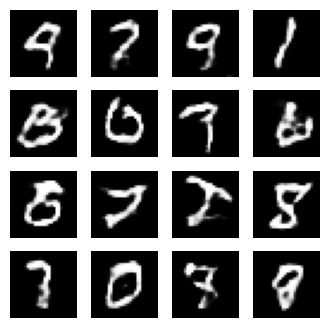

In [ ]:
EPOCHS = 50 #50 # you can start with less to debug
train(train_dataset, EPOCHS)

#### More utils you may want to use:

If you need to **restore the latest checkpoint** to continue training later:

In [ ]:
# https://www.tensorflow.org/guide/checkpoint
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

If you want to **create a GIF to visualize the process**:


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

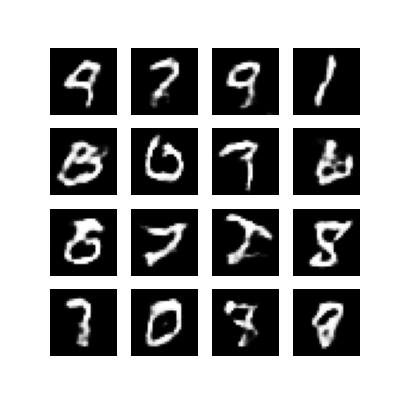

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-23-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



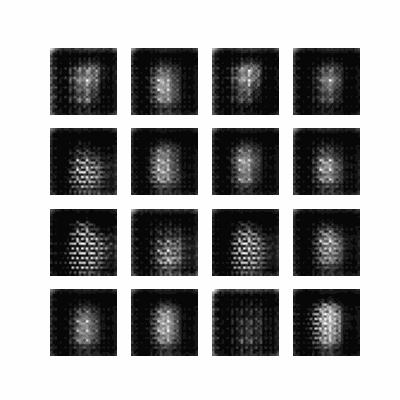

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Model 2 results - WGAN

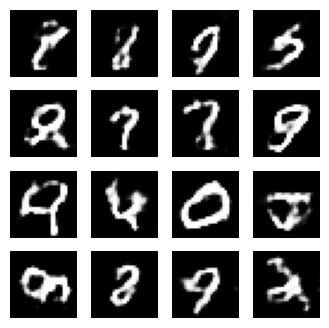

In [ ]:
EPOCHS = 50 #50 # you can start with less to debug
train(train_dataset, EPOCHS)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

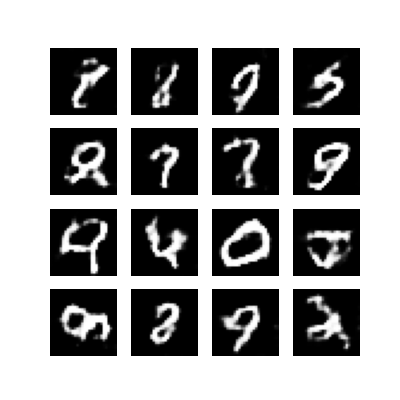

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-24-4b7b1659aa67>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-24-4b7b1659aa67>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



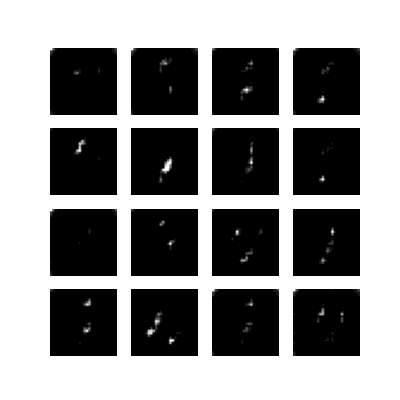

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### QUESTION 3: Compare the GAN models you have trained

How would you evaluate the quality of these two GANs? E.g., what kind of plots or logs would be helpful to see? Any loss values? what would you expect to see on them?
(You can add a few lines of code to compute something or generate plots if you need to, but you can also just discuss how you would do this).

If you **used a MNIST dataset** (digits or fashion):
* From your two models, which one do you think it's better?

If you **used the CIFAR-10 dataset**: since this one can take much longer to train, you **only need to train your own variation**.

ANSWER 3:


Just from the generated images, both models show a fairly similar performance. However, if we were to generate more images and plot loss values over time we would find a smoother, more stable convergence for the second model. This is because the Wesserstein loss function introduces several performance and stability improvements that can be helpful for training on more complex datasets. WGANs are less prone to mode collapse - a situation that happens when the GAN only generates a subset of possible samples, ignoring the diversity of the original dataset -, and this loss function helps the generator cover a broader range of the data distribution. At the same time, the Wasserstein distance provides a more meaningful measure of the distance between the real and the generated distributions, allowing more effective updates on the generator. Vanishing and explodient gradients are also mitigated by using gradient penalty, and  Lipschitz continuity prevents the generator from making drastic updates.